## Project Overview

- Objective: hourly energy demand forecasting
- Target: load, price
- Type: day ahead (24h)
- Source: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

## Datasets

1. energy_dataset:

    Power system (actuals by hour)
    - time — Timestamp of the delivery hour (usually ISO 8601). Use UTC internally; handle DST carefully.

    - generation biomass — Electricity generated from biomass, in MW (instantaneous average over the hour).

    - generation fossil brown coal/lignite — Lignite-fired generation, MW.

    - generation fossil coal-derived gas — Coal-gas derived generation, MW.

    - generation fossil gas — Natural gas generation, MW.

    - generation fossil hard coal — Hard/bituminous coal generation, MW.

    - generation fossil oil — Oil-fired generation, MW.

    - generation fossil oil shale — Oil-shale–based generation, MW.

    - generation fossil peat — Peat-fueled generation, MW.

    - generation geothermal — Geothermal generation, MW.

    - generation hydro pumped storage aggregated — Net pumped-storage generation (aggregate), MW (positive = generating).

    - generation hydro pumped storage consumption — Pumped-storage pumping load/consumption, MW (positive = consuming).

    - generation hydro run-of-river and poundage — Run-of-river hydro generation, MW.

    - generation hydro water reservoir — Reservoir hydro generation, MW.

    - generation marine — Tidal/wave (marine) generation, MW.

    - generation nuclear — Nuclear generation, MW.

    - generation other — Other unspecified generation sources, MW.

    - generation other renewable — Other renewables not listed elsewhere (e.g., biomass waste-to-energy if categorized so), MW.

    - generation solar — Solar PV generation, MW.

    - generation waste — Waste-to-energy generation, MW.

    - generation wind offshore — Offshore wind generation, MW.

    - generation wind onshore — Onshore wind generation, MW.

    Forecasts (known at/ before the forecast time)

    - forecast solar day ahead — Day-ahead solar generation forecast, MW for each hour of the next day (feature; avoid using realized future solar).

    - forecast wind offshore day ahead (your list says “offshore eday ahead”; assume a typo) — Day-ahead offshore wind forecast, MW.

    - forecast wind onshore day ahead — Day-ahead onshore wind forecast, MW.

    - total load forecast — System load forecast made day-ahead or intra-day, MW (feature; do not use future actuals).

    - price day ahead — Day-ahead market price for the delivery hour, EUR/MWh (can be negative).

    Load & price targets
    - total load actual — Realized system load (demand), MW.

    - price actual — Realized/settlement price (if provided; may be balancing or intraday realized), EUR/MWh.

2. Weather (typically hourly, by city/area)
    - dt_iso — Weather observation/forecast timestamp (ISO 8601; confirm whether this is UTC or local from the source).

    - city_name — Name/identifier of the weather location (join key if multiple stations).

    - temp — Air temperature at 2 m, °C.

    - temp_min — Min temperature over the last/next observation window, °C (API-dependent).

    - temp_max — Max temperature over the last/next observation window, °C.

    - pressure — Atmospheric pressure at sea level, hPa.

    - humidity — Relative humidity, %.

    - wind_speed — Wind speed, typically m/s (sometimes km/h; check the data source).

    - wind_deg — Wind direction in degrees (0–360, meteorological).

    - rain_1h — Rainfall volume in the last 1 h, mm.

    - rain_3h — Rainfall volume in the last 3 h, mm.

    - snow_3h — Snowfall volume in the last 3 h, mm (water equivalent).

    - clouds_all — Cloudiness, % (0–100).

    - weather_id — Weather condition code (numeric category).

    - weather_main — High-level weather category (e.g., Rain, Snow).

    - weather_description — Human-readable description (e.g., “light rain”).

    - weather_icon — Icon code string (display-only; not predictive).

## 0. Set Up

In [1]:
# ===== Standard library =====
from datetime import datetime
import warnings

# ===== Third-party =====
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

# PyTorch Lightning
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# Darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae
from darts.models import BlockRNNModel

# Silence unnecessary warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("darts").setLevel(logging.ERROR)

/home/admin_ml/Jackson/projects/darts/Time-Series-Training/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [2]:
# display all pandas columns
pd.set_option('display.max_columns', None)

# display first few rows of the DataFrame
pd.set_option('display.max_rows', 100)


## 1. EDA

In [3]:
energy_data = pd.read_csv("/mnt/datasets/energy_dataset.csv", parse_dates=["time"])
weather_data = pd.read_csv("/mnt/datasets/weather_features.csv", parse_dates=["dt_iso"])

### 1.1 Energy dataset

In [4]:
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
# Overall information
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [6]:
# number of unique 
energy_data.nunique()

time                                           35064
generation biomass                               423
generation fossil brown coal/lignite             956
generation fossil coal-derived gas                 1
generation fossil gas                           8297
generation fossil hard coal                     7266
generation fossil oil                            321
generation fossil oil shale                        1
generation fossil peat                             1
generation geothermal                              1
generation hydro pumped storage aggregated         0
generation hydro pumped storage consumption     3311
generation hydro run-of-river and poundage      1684
generation hydro water reservoir                7029
generation marine                                  1
generation nuclear                              2388
generation other                                 103
generation other renewable                        78
generation solar                              

In [7]:
# Drop null columns, constant columns, useless columns
drop_cols = ["generation fossil coal-derived gas", 
             "generation fossil oil shale", 
             "generation fossil peat", 
             "generation geothermal", 
             "generation hydro pumped storage aggregated", 
             "generation marine", 
             "generation wind offshore", 
             "forecast wind offshore eday ahead",
             "price day ahead",
             "total load forecast"
             ]

energy_data = energy_data.drop(columns=drop_cols)

In [8]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [9]:
# Convert time column to datetime type and set it as index
energy_data["time"] = pd.to_datetime(energy_data["time"], utc=True, infer_datetime_format=True).dt.floor("h")
energy_data = energy_data.set_index("time").sort_index()

In [10]:
# duplicated rows
duplicate_rows = energy_data[energy_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [11]:
# time continuity check
time_diff = energy_data.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals: {len(missing_intervals)}")

Number of missing time intervals: 0


In [12]:
# null values
energy_data.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load actual                              36
price actual                                    0
dtype: int64

In [13]:
# total rows
total_rows = energy_data.shape[0]
print(f"Total rows: {total_rows}")

Total rows: 35064


Comparing the total number of the samples, there are only few missing features. We only need to check the target column: total load actual:

In [14]:
# find the missing rows of the target column 'total load actual'
missing_target_rows = energy_data[energy_data["total load actual"].isnull()]

missing_target_rows

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load actual,price actual
time,,,,,,,,,,,,,,,,,,
2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3932.0,9258.0,NaN,79.14
2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236.0,9156.0,NaN,73.95
2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215.0,9072.0,NaN,71.93
2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050.0,8779.0,NaN,71.50
2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3728.0,8426.0,NaN,71.85
2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3175.0,7946.0,NaN,80.53
2015-01-28 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4136.0,6223.0,NaN,77.62
2015-02-01 06:00:00+00:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,18.0,3141.0,NaN,16.98
2015-02-01 07:00:00+00:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,63.0,3165.0,NaN,19.56


The gaps are scattered across the time range, so we apply a forward fill to impute short gaps and remove any initial missing values.

In [15]:
print(f"total rows: {energy_data.shape[0]}, missing target rows: {missing_target_rows.shape[0]} before imputation:")
energy_data = energy_data.ffill().dropna()
energy_data.isnull().sum()

total rows: 35064, missing target rows: 36 before imputation:


generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load actual                              0
price actual                                   0
dtype: int64

In [16]:
# Overall information after cleaning
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

### 1.2 Weather

In [17]:
weather_data[weather_data["city_name"]=="Seville"].head(10)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
142839,2015-01-01 00:00:00+01:00,Seville,273.375,273.375,273.375,1039,75,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142840,2015-01-01 01:00:00+01:00,Seville,273.375,273.375,273.375,1039,75,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142841,2015-01-01 02:00:00+01:00,Seville,274.086,274.086,274.086,1039,71,3,27,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142842,2015-01-01 03:00:00+01:00,Seville,274.086,274.086,274.086,1039,71,3,27,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142843,2015-01-01 04:00:00+01:00,Seville,274.086,274.086,274.086,1039,71,3,27,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142844,2015-01-01 05:00:00+01:00,Seville,274.592,274.592,274.592,1039,81,4,57,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142845,2015-01-01 06:00:00+01:00,Seville,274.592,274.592,274.592,1039,81,4,57,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142846,2015-01-01 07:00:00+01:00,Seville,274.592,274.592,274.592,1039,81,4,57,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142847,2015-01-01 08:00:00+01:00,Seville,275.651,275.651,275.651,1041,73,2,32,0.0,0.0,0.0,0,800,clear,sky is clear,01d
142848,2015-01-01 09:00:00+01:00,Seville,275.651,275.651,275.651,1041,73,2,32,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [18]:
# convert dt_iso to datetime
weather_data["time"] = pd.to_datetime(weather_data["dt_iso"], utc=True, infer_datetime_format=True).dt.floor("h")
weather_data = weather_data.drop(columns=["dt_iso"])

In [19]:
# Overall information
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            178396 non-null  object             
 1   temp                 178396 non-null  float64            
 2   temp_min             178396 non-null  float64            
 3   temp_max             178396 non-null  float64            
 4   pressure             178396 non-null  int64              
 5   humidity             178396 non-null  int64              
 6   wind_speed           178396 non-null  int64              
 7   wind_deg             178396 non-null  int64              
 8   rain_1h              178396 non-null  float64            
 9   rain_3h              178396 non-null  float64            
 10  snow_3h              178396 non-null  float64            
 11  clouds_all           178396 non-null  int64              
 12  we

In [20]:
# number of unique
print("total rows:", weather_data.shape[0])
weather_data.nunique()

total rows: 178396


city_name                  5
temp                   20743
temp_min               18553
temp_max               18591
pressure                 190
humidity                 100
wind_speed                36
wind_deg                 361
rain_1h                    7
rain_3h                   89
snow_3h                   66
clouds_all                97
weather_id                38
weather_main              12
weather_description       43
weather_icon              24
time                   35064
dtype: int64

In [21]:
# for the sake of simplicity, we will temporarily drop objective columns: weather_description 
weather_data = weather_data.drop(columns=["weather_main", "weather_icon", "weather_description"])

In [22]:
# check duplicated rows in different citys

duplicate_rows_weather = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data: {duplicate_rows_weather.shape[0]}")

# drop duplicate rows
weather_data = weather_data.drop_duplicates(subset=['city_name', 'time'])

# Check duplicates again
duplicate_rows_weather_check = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data after dropping duplicates: {duplicate_rows_weather_check.shape[0]}")

Number of duplicate rows in weather data: 3076
Number of duplicate rows in weather data after dropping duplicates: 0


In [23]:
# set time column as index
weather_data = weather_data.set_index("time").sort_index()

In [24]:
# check time continuity for each city
missing_counts = (weather_data
    .groupby('city_name')
    .apply(lambda g: g.index.to_series().diff().dropna().ne(pd.Timedelta('1H')).sum())
)
print(missing_counts)

city_name
 Barcelona    0
Bilbao        0
Madrid        0
Seville       0
Valencia      0
dtype: int64


In [25]:
# null values
weather_data.isnull().sum()

city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
weather_id    0
dtype: int64

In [26]:
# check object columns in details
object_cols = weather_data.select_dtypes(include=['object']).columns
for col in object_cols:
    print(f"Value counts for column '{col}':")
    print(weather_data[col].value_counts())
    print()

Value counts for column 'city_name':
city_name
Valencia      35064
Seville       35064
Madrid        35064
 Barcelona    35064
Bilbao        35064
Name: count, dtype: int64



In [27]:
# statistical summary
weather_data.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


**Key Findings:**

- Pressure shows both low and extreme high outliers;
- wind speed has a heavy upper tail; 
- rain/snow: Mostly zeros, occasional spikes.. 

We’ll confirm this through obvervization soon.

### 1.3 Visualization

#### 1.3.1 energy data visualization

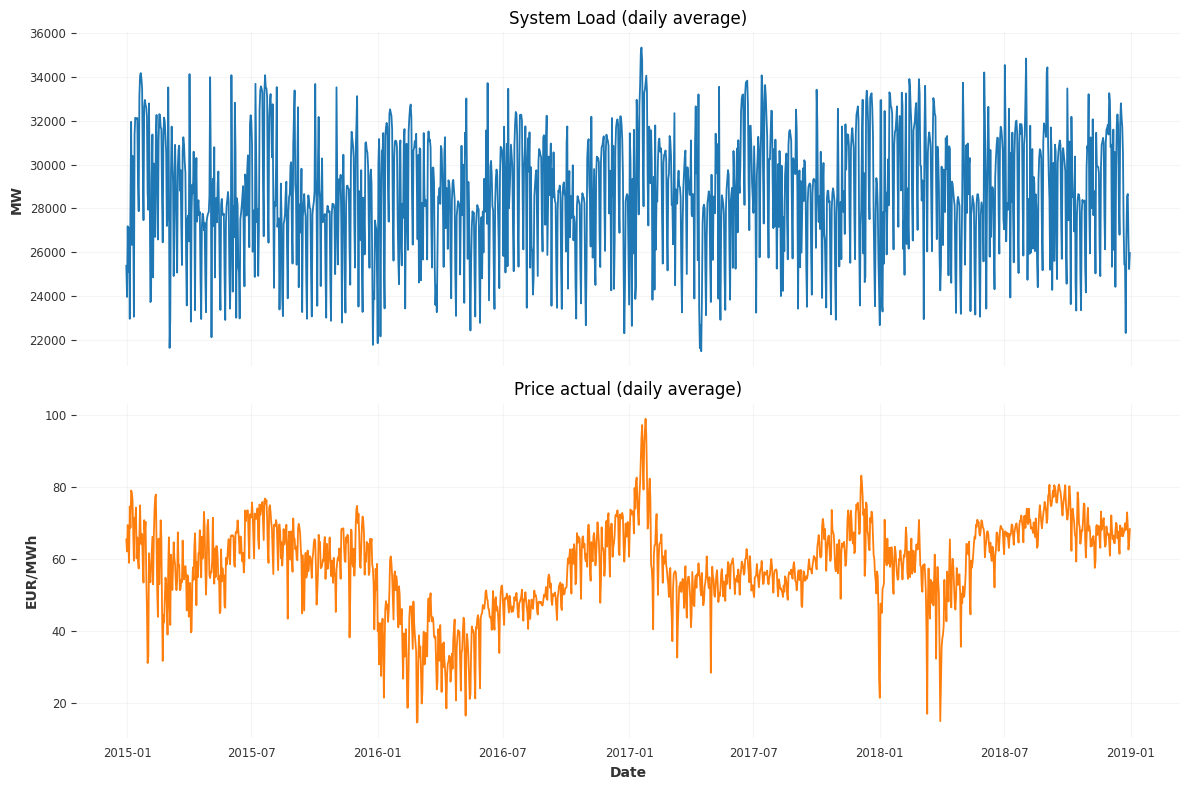

In [28]:
# Load & Price: Overall Trend (Hourly → Daily Mean, Denoised)

daily = energy_data[['total load actual','price actual']].resample('D').mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(daily.index, daily['total load actual'], label='Load (daily mean)', color='tab:blue')
ax[0].set_ylabel('MW')
ax[0].set_title('System Load (daily average)')
ax[0].grid(True, alpha=0.3)

ax[1].plot(daily.index, daily['price actual'], label='Price actual (daily mean)', color='tab:orange')
ax[1].set_ylabel('EUR/MWh')
ax[1].set_title('Price actual (daily average)')
ax[1].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

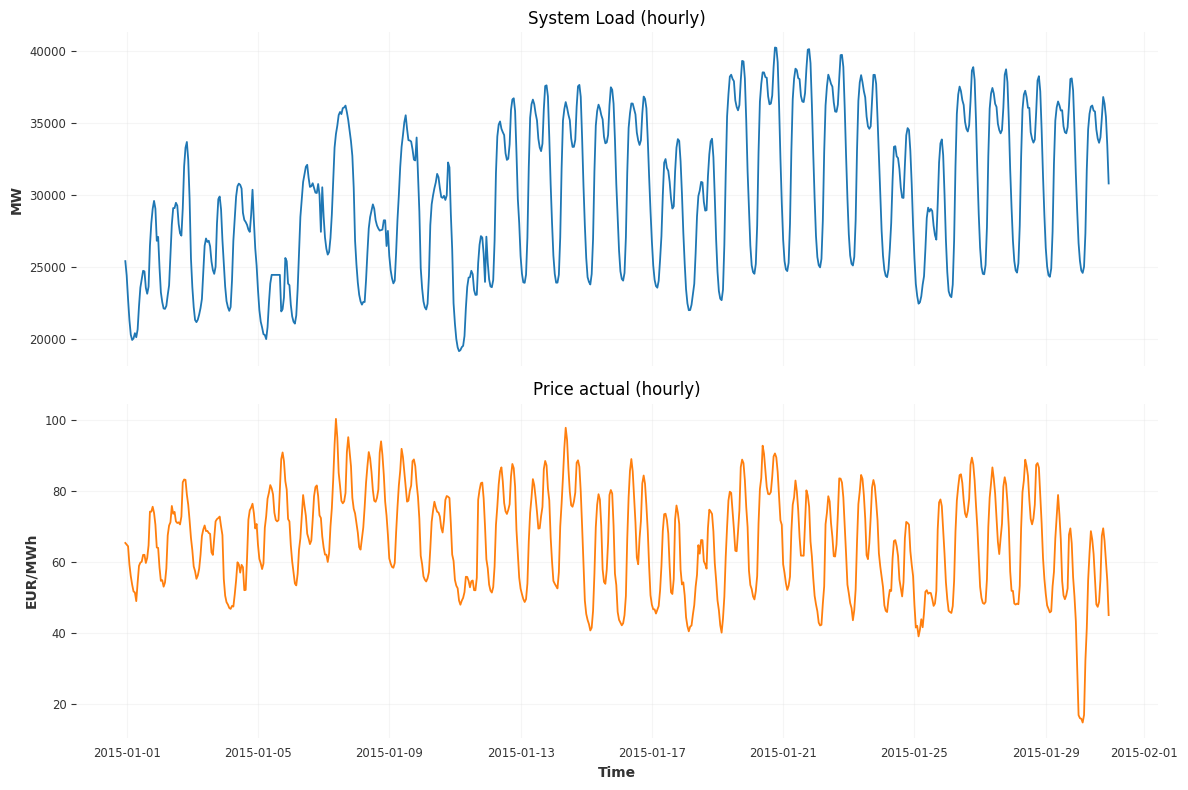

In [29]:
# Hourly Load & Price in a small time window
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(energy_data.index[:24*30], energy_data['total load actual'][:24*30], label='Load (hourly)', color='tab:blue')
ax[0].set_ylabel('MW')
ax[0].set_title('System Load (hourly)')
ax[0].grid(True, alpha=0.3)

ax[1].plot(energy_data.index[:24*30], energy_data['price actual'][:24*30], label='Price actual (hourly)', color='tab:orange')
ax[1].set_ylabel('EUR/MWh')
ax[1].set_title('Price actual (hourly)')
ax[1].grid(True, alpha=0.3)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

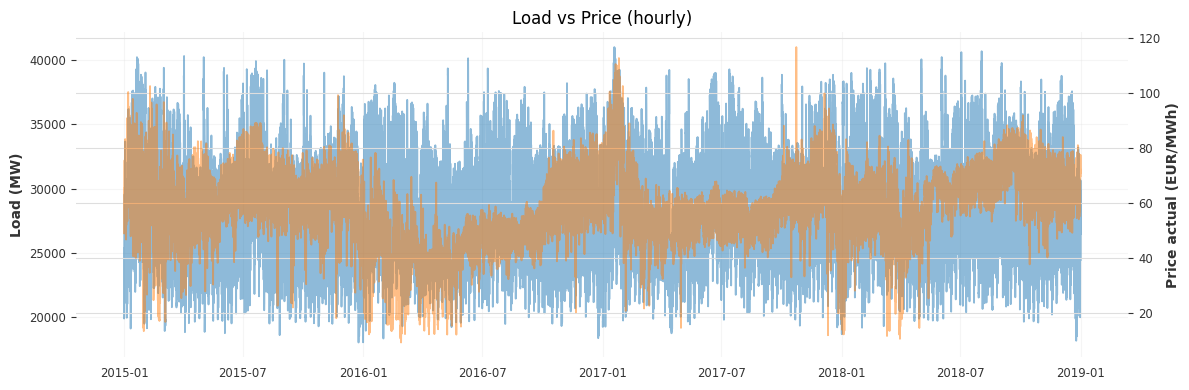

In [30]:
# Load & Price: Dual-Axis View (Hourly Detail)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(energy_data.index, energy_data['total load actual'], alpha=0.5, color='tab:blue')
ax.set_ylabel('Load (MW)')
ax.grid(True, alpha=0.3)
ax2 = ax.twinx()
ax2.plot(energy_data.index, energy_data['price actual'], alpha=0.5, color='tab:orange')
ax2.set_ylabel('Price actual (EUR/MWh)')
ax.set_title('Load vs Price (hourly)')   
plt.tight_layout()
plt.show()


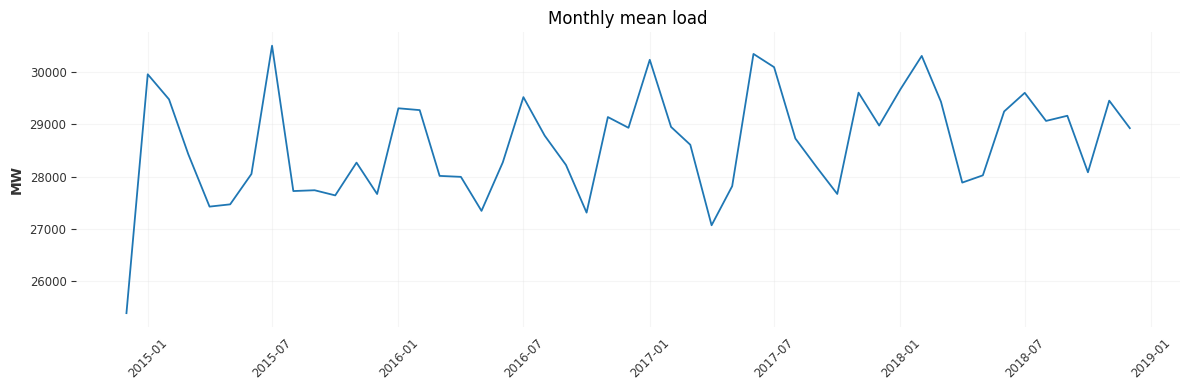

In [31]:
# Seasonality – Monthly

monthly = energy_data['total load actual'].resample('MS').mean()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly.index, monthly.values, color='tab:blue')
ax.set_title('Monthly mean load')
ax.set_ylabel('MW')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

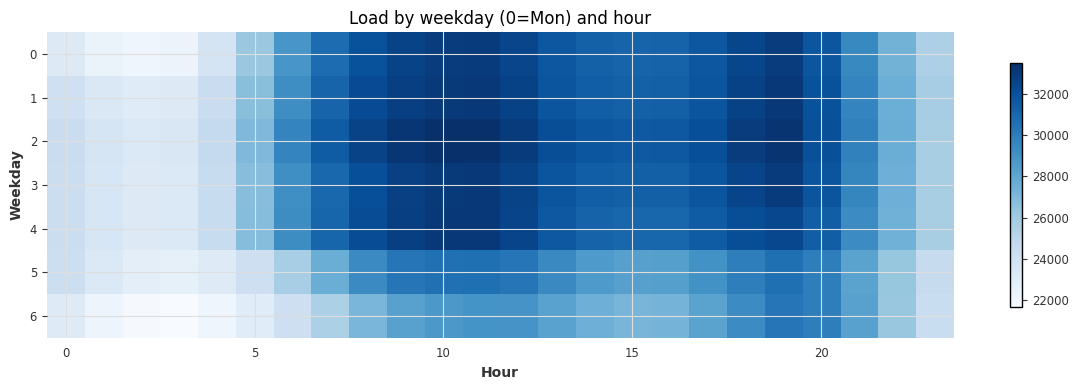

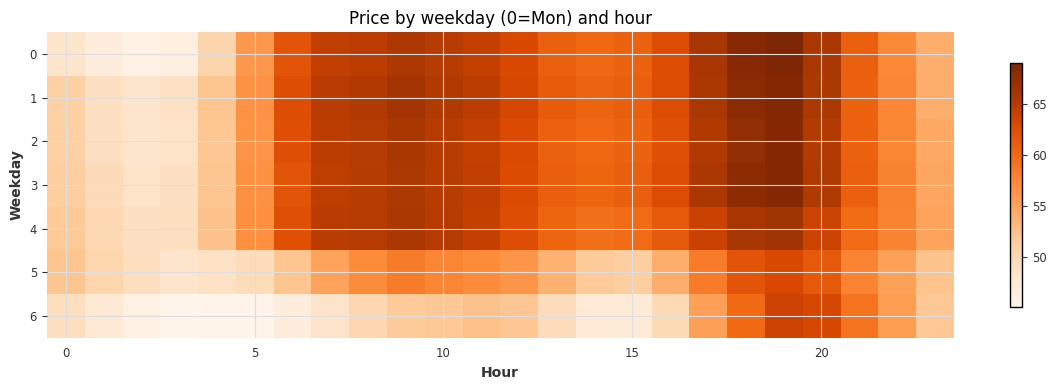

In [32]:
# Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['total load actual'].groupby([energy_data.index.dayofweek,energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(gp, aspect='auto', cmap='Blues')
ax.set_title('Load by weekday (0=Mon) and hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
fig.tight_layout()
plt.show()


# Price: Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['price actual'].groupby([energy_data.index.dayofweek,
                                               energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(gp, aspect='auto', cmap='Oranges')
ax.set_title('Price by weekday (0=Mon) and hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
fig.tight_layout()
plt.show()



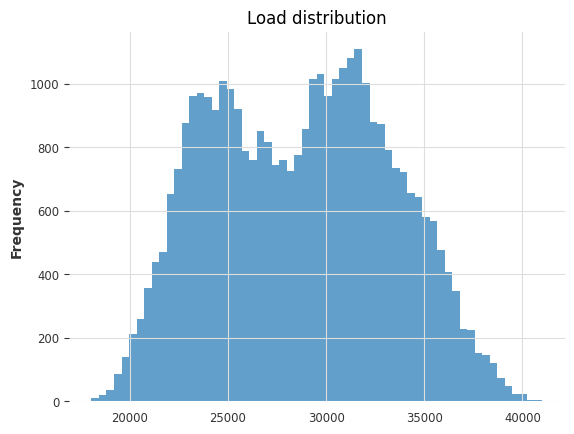

In [33]:
# load distribution
yL = energy_data["total load actual"]
yL.plot(kind="hist", bins=60, alpha=.7, title="Load distribution", color='tab:blue')
plt.show()

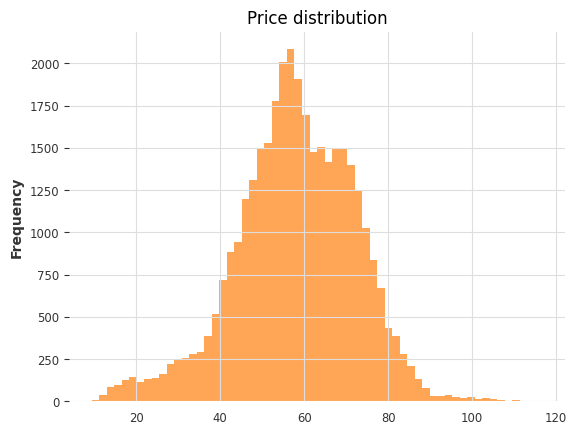

Price < 0 ratio: 0.0


In [34]:
# price distribution
yP = energy_data["price actual"]
yP.plot(kind="hist", bins=60, alpha=.7, title="Price distribution", color='tab:orange')
plt.show()
print("Price < 0 ratio:", (yP<0).mean())


~normarlization distribution, no need log1p transformation

In [35]:
def plot_acf_clean(s, max_lag=200, title="", highlight=(), daily=False,
                   color='tab:blue', highlight_color='k'):
    s = s.dropna()
    if daily:
        s = s.resample("D").mean()

    fig, ax = plt.subplots(figsize=(12, 4))

    plot_acf(
        s, lags=max_lag, ax=ax, zero=False, alpha=0.05,
        vlines_kwargs={'colors': color, 'linewidth': 1.2, 'alpha': 0.95},
        marker='o'
    )

    ax.set_title(title)
    ax.set_xlim(0, max_lag)
    ax.set_ylim(-1.0, 1.0)
    ax.grid(True, alpha=0.3)

    for k in highlight:
        if k <= max_lag:
            ax.axvline(k, color=highlight_color, linestyle="--", linewidth=0.8, alpha=0.7)
            ax.text(k+1, 0.88, str(k), fontsize=9, alpha=0.7, color=highlight_color)

    plt.tight_layout()
    plt.show()

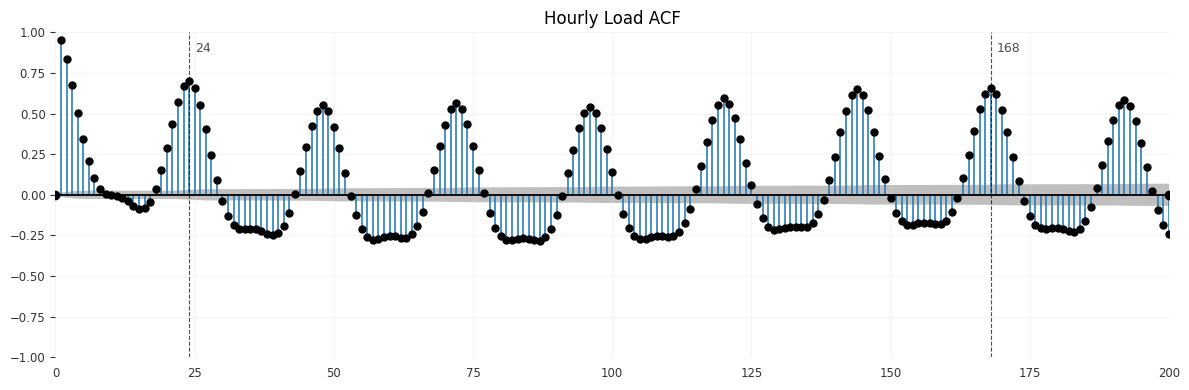

In [36]:
# Load: ACF (Hourly)
plot_acf_clean(energy_data['total load actual'], max_lag=200,
               title='Hourly Load ACF', color='tab:blue', highlight=(24, 168))

Action Plan: 
- Trees: load lags: 1, 2, 3, 24, 25, 48, 168 + rolling stats: 24, 168 on shift (1)
- NN : Encoder length > 168

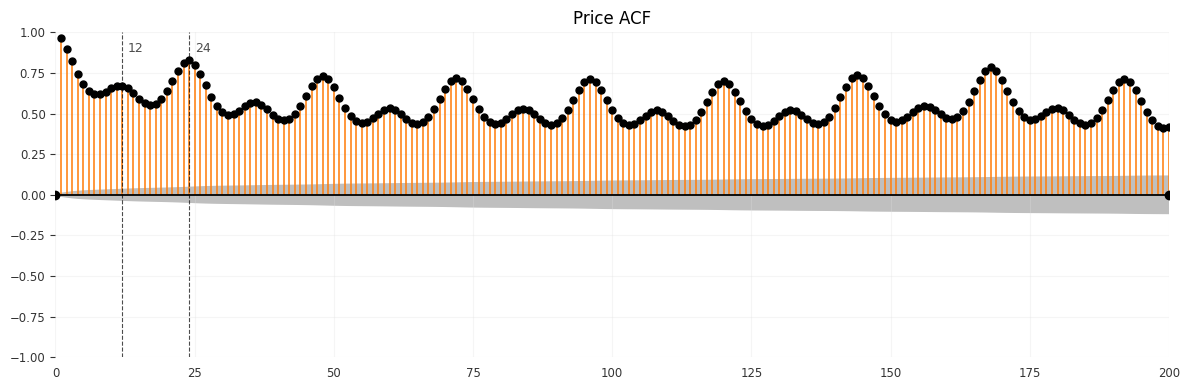

In [37]:
# Price: ACF (Hourly)
plot_acf_clean(energy_data['price actual'], max_lag=200,
               title='Price ACF', color='tab:orange', highlight=(12, 24))

Action Plan: lag 1,2,12,24

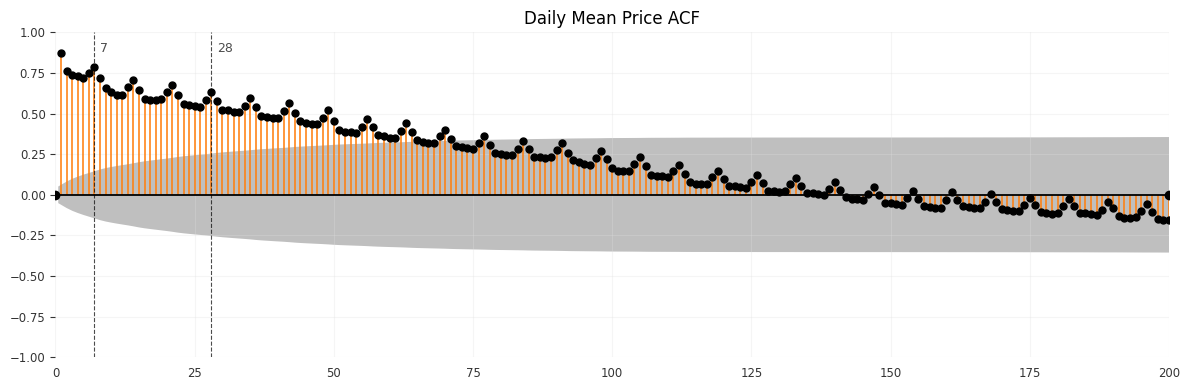

In [38]:
# Price: ACF (daily mean)
plot_acf_clean(energy_data['price actual'], max_lag=200,
               title='Daily Mean Price ACF', color='tab:orange', highlight=(7, 28), daily=True)

actions: 
- Trees: price daily lags: 1, 2, 7, 14, 28 + rolling stats: 7, 14, 28 on shift(1)
- NN: Encoder Length >= 168
- diff in 1 day, 7 days

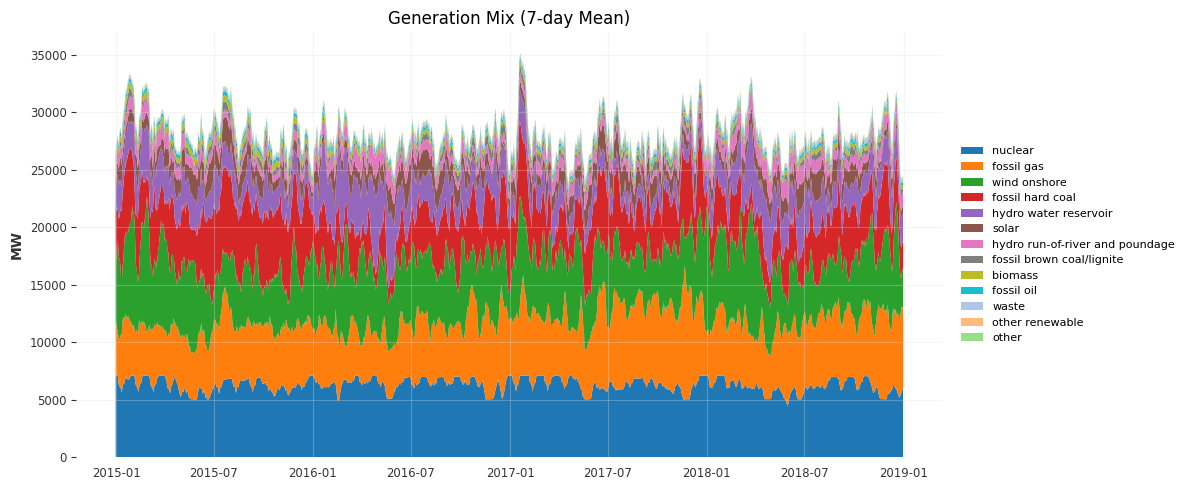

In [39]:
gen_cols = [c for c in energy_data.columns if c.startswith('generation ') and 'pumped storage consumption' not in c] 

# # Daily mean to reduce visual noise 
gen_daily = energy_data[gen_cols].resample('D').mean() 
gen_smooth = gen_daily.rolling(window=7, min_periods=1).mean()

order = gen_smooth.mean().sort_values(ascending=False).index
labels = [c.replace('generation ', '') for c in order]

base = list(plt.colormaps['tab20'].colors)
idx = list(range(0,20,2)) + list(range(1,20,2)) 
colors = [base[idx[i % 20]] for i in range(len(order))]


fig, ax = plt.subplots(figsize=(12,5))
ax.stackplot(gen_smooth.index, gen_smooth[order].T.values,
             labels=labels, colors=colors, linewidth=0)
ax.set_title('Generation Mix (7-day Mean)')
ax.set_ylabel('MW'); ax.grid(True, alpha=0.3)
ax.legend(ncols=1, fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout(); plt.show()


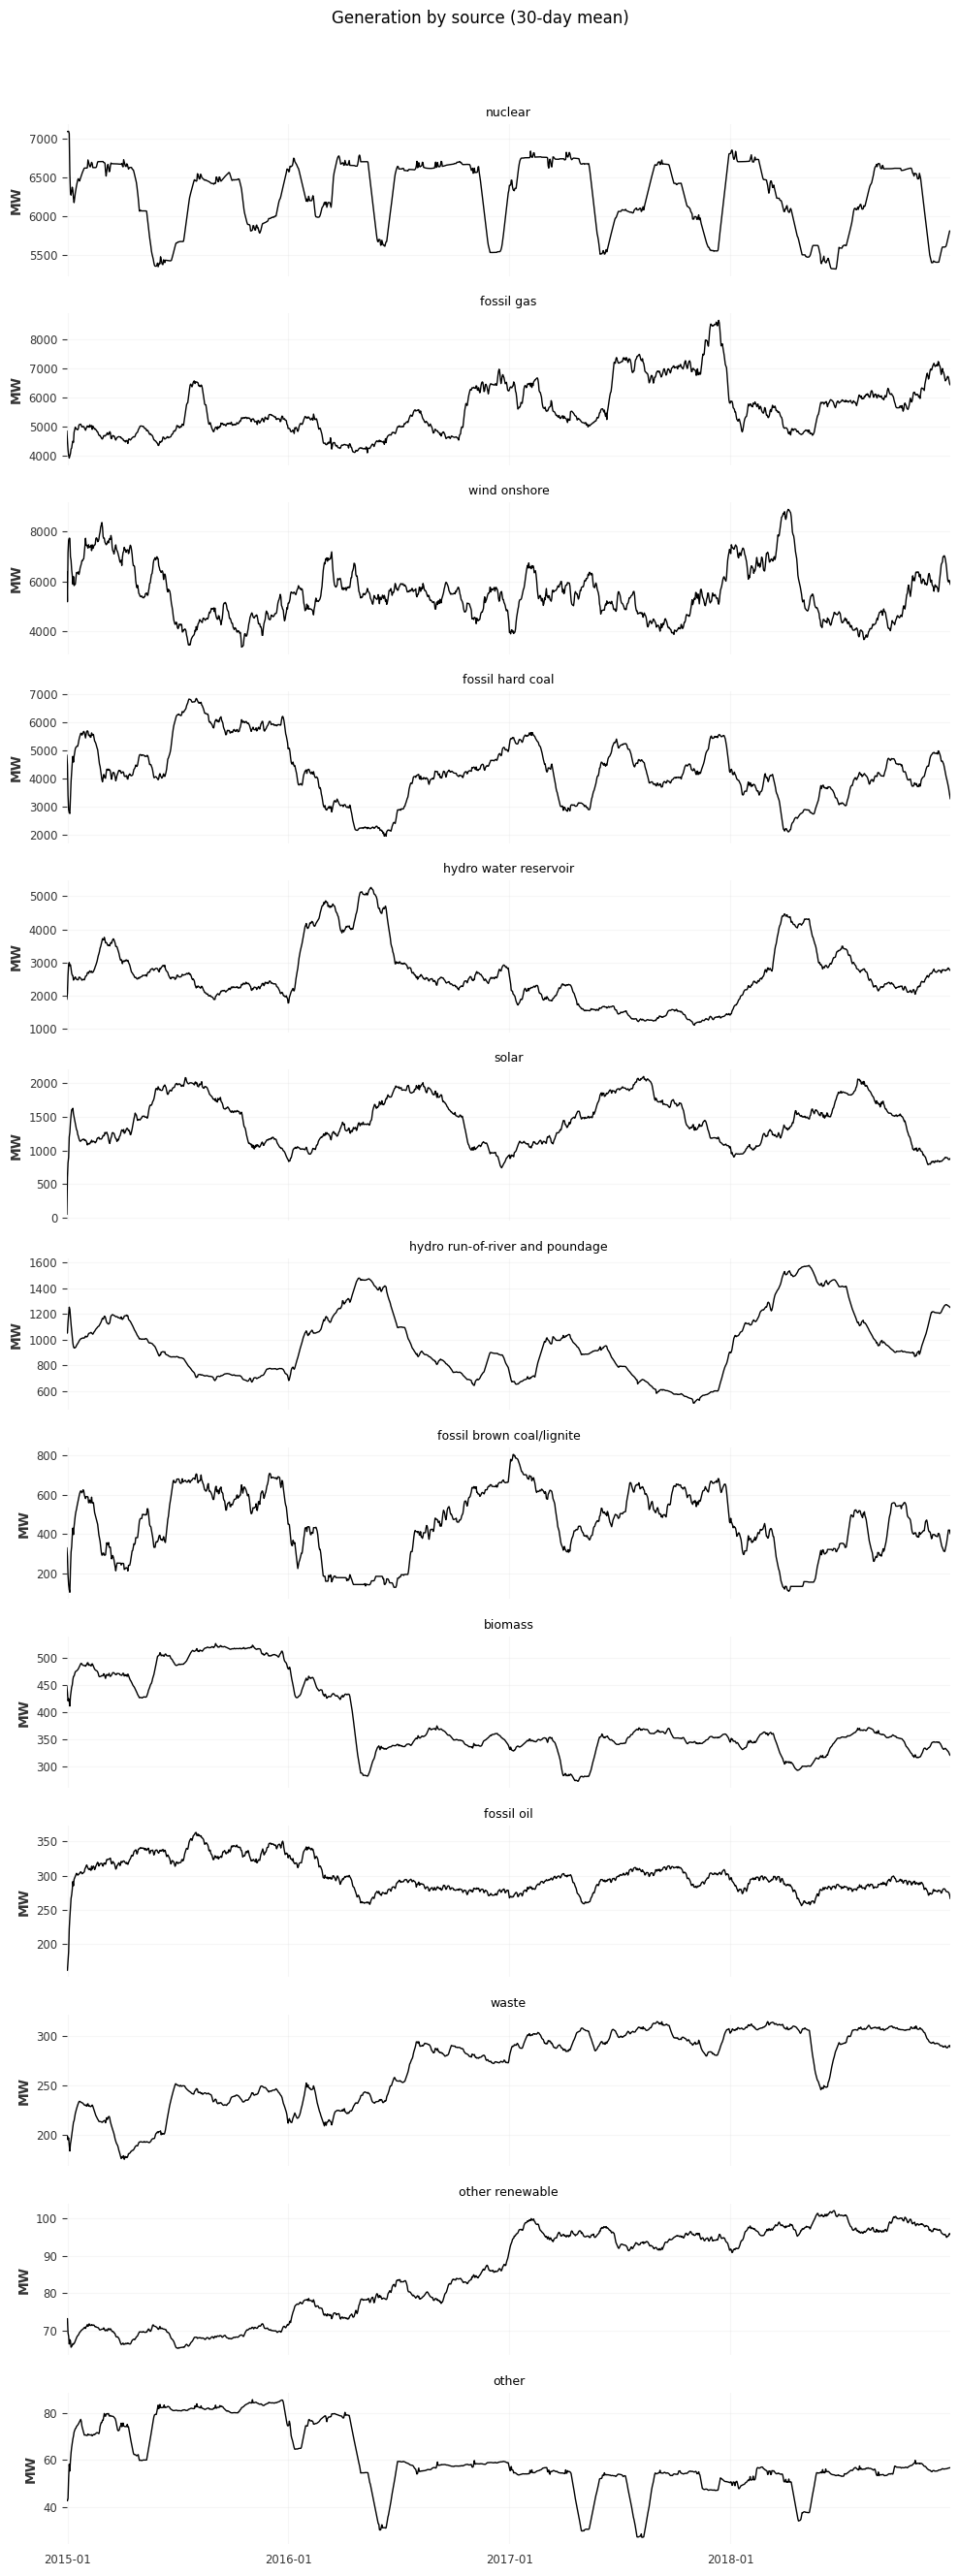

In [40]:
# Generation by Source (30-day Mean): Small Multiples

# 1) Prepare series: daily mean + 30-day rolling mean; order by long-run average
gen_cols = [c for c in energy_data.columns
            if c.startswith('generation ') and 'pumped storage consumption' not in c]
gen_daily  = energy_data[gen_cols].resample('D').mean()
gen_roll30 = gen_daily.rolling(30, min_periods=1).mean()
order = gen_roll30.mean().sort_values(ascending=False).index
titles = [c.replace('generation ', '') for c in order]

# 2) Small multiples: share the same X axis across plots, keep independent Y axes
n = len(order); ncols = 1
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2*nrows), sharex=True)  # sharex=True !
axes = axes.ravel()

xmin, xmax = gen_roll30.index.min(), gen_roll30.index.max()
locator = mdates.YearLocator()       
fmt     = mdates.DateFormatter('%Y-%m')

for i, col in enumerate(order):
    ax = axes[i]
    ax.plot(gen_roll30.index, gen_roll30[col], linewidth=1.0)
    ax.set_title(titles[i], fontsize=9)
    ax.set_xlim(xmin, xmax)          
    ax.grid(True, alpha=0.25)
    if i % ncols == 0:
        ax.set_ylabel('MW')          
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)

# 3) Hide X labels on inner plots; show them only on the bottom row
for ax in axes:
    ax.label_outer()

# Turn off any unused subplots (when grid has extra slots)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Generation by source (30-day mean)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


**Findings**

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.


#### 1.3.2 weather data visualization

In [41]:
weather_data.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800
2014-12-31 23:00:00+00:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,800
2014-12-31 23:00:00+00:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,800
2014-12-31 23:00:00+00:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,800
2014-12-31 23:00:00+00:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800


In [42]:
def ez_box(df, x, y, title=None, percent=False, figsize=(12,4), rotation=12, palette='Set2'):
    """Simple, clean boxplot with outliers kept"""
    sns.set_theme(style="whitegrid", context="notebook")
    flierprops = dict(marker='o', markersize=2, markerfacecolor='none',
                      markeredgecolor='0.3', alpha=0.5)
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    sns.boxplot(data=df, x=x, y=y,
                showfliers=True, fliersize=2, flierprops=flierprops,
                palette=palette, width=0.6, linewidth=1.2, ax=ax)
    ax.set(title=title or f'{y} by {x}', xlabel=x, ylabel=y)
    if rotation: ax.tick_params(axis='x', labelrotation=rotation)
    if percent:  ax.set_ylim(-5, 105)
    ax.grid(True, axis='y', alpha=0.25)
    return ax


<Axes: title={'center': 'Temperature by City'}, xlabel='city_name', ylabel='temp'>

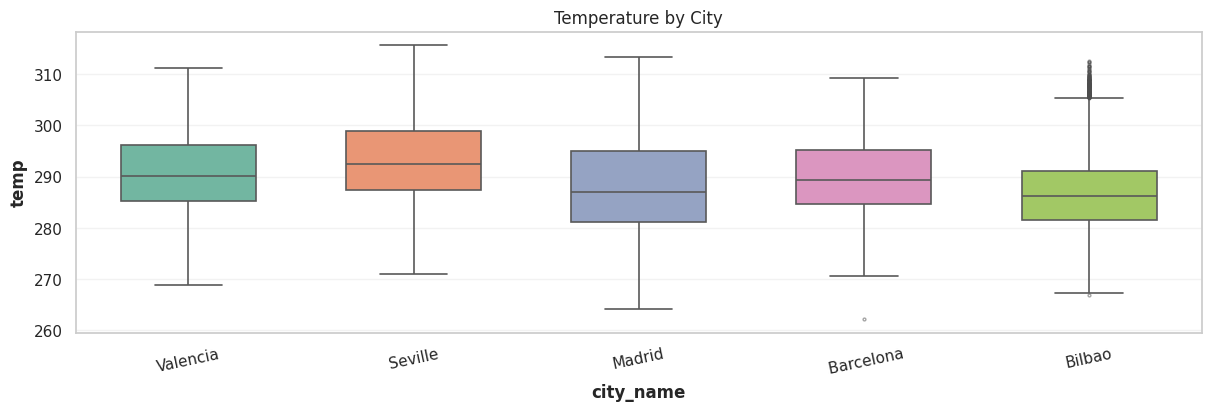

In [43]:
# 1) Temperature
ez_box(weather_data, 'city_name', 'temp', 'Temperature by City')

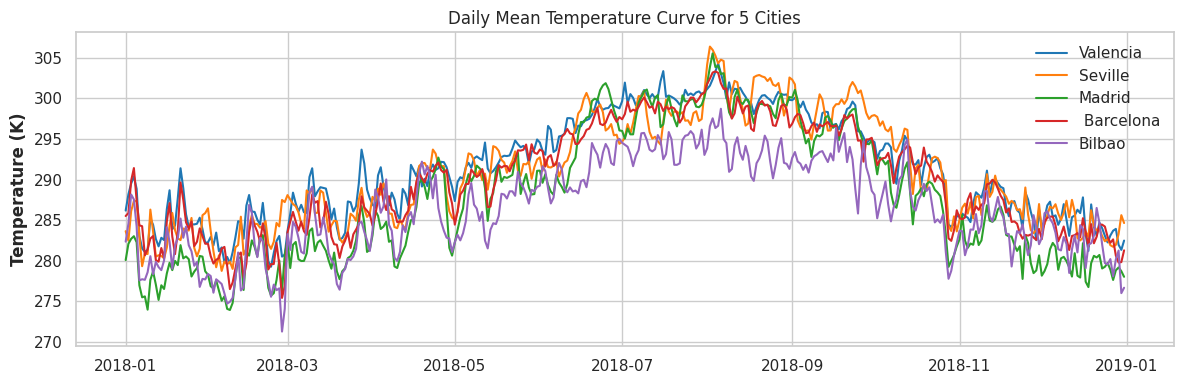

In [44]:
# plot daily mean temperature curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_temp = weather_data[weather_data['city_name'] == city]['temp'].sort_index().resample('D').mean()
    ax.plot(city_temp[-365:].index, city_temp[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Temperature Curve for 5 Cities')
ax.set_ylabel('Temperature (K)')
ax.legend()
plt.tight_layout()
plt.show()


Findings: tempereture envolves similar across different cities

<Axes: title={'center': 'Pressure Distribution by City'}, xlabel='city_name', ylabel='pressure'>

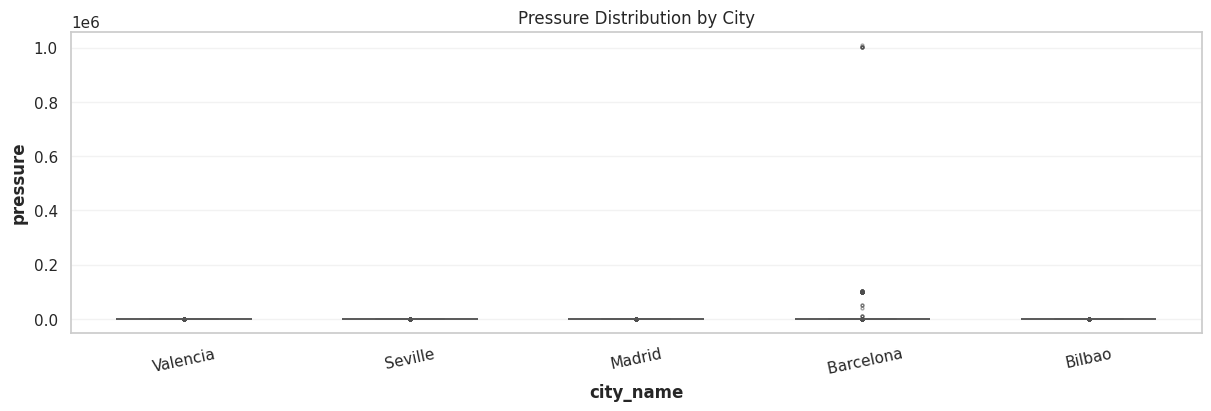

In [45]:
# 2) Pressure
ez_box(weather_data, 'city_name', 'pressure', 'Pressure Distribution by City')

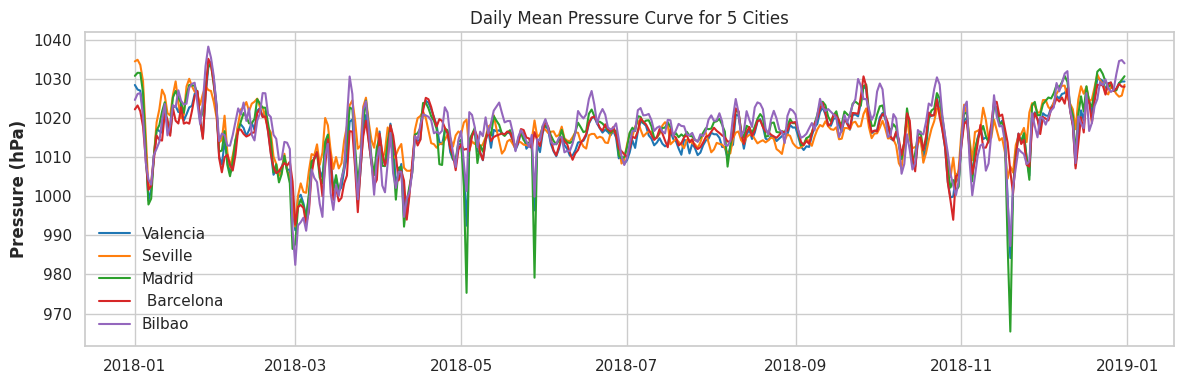

In [46]:
# pressure daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_pressure = weather_data[weather_data['city_name'] == city]['pressure'].sort_index().resample('D').mean()
    ax.plot(city_pressure[-365:].index, city_pressure[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Pressure Curve for 5 Cities')
ax.set_ylabel('Pressure (hPa)')
ax.legend()
plt.tight_layout()
plt.show()

Findings: 
- Pressure envoles similar across different cities.
- Outliers: the pressure unit might be wrong

In [ ]:
# visualization of wind speed data
ez_box(weather_data, 'city_name', 'wind_speed', 'Wind Speed Distribution by City')

In [ ]:
# wind speed daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):    
    city_wind = weather_data[weather_data['city_name'] == city]['wind_speed'].sort_index().resample('D').mean()
    ax.plot(city_wind[-365:].index, city_wind[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Wind Speed Curve for 5 Cities')
ax.set_ylabel('Wind Speed (m/s)')
ax.legend()
plt.tight_layout()
plt.show()

Outliers: high speed

In [ ]:
# humidity
ez_box(weather_data, 'city_name', 'humidity', 'Humidity Distribution by City')

In [ ]:
# humidity daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_humidity = weather_data[weather_data['city_name'] == city]['humidity'].sort_index().resample('D').mean()
    ax.plot(city_humidity[-365:].index, city_humidity[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Humidity Curve for 5 Cities')
ax.set_ylabel('Humidity (%)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# visualization of rain_1h data
ez_box(weather_data, 'city_name', 'rain_1h', 'Rain (1h) Distribution by City')

In [ ]:
# rain_1h daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_rain = weather_data[weather_data['city_name'] == city]['rain_1h'].sort_index().resample('D').mean()
    ax.plot(city_rain[-365:].index, city_rain[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Rain (1h) Curve for 5 Cities')
ax.set_ylabel('Rain (mm)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
weather_data["rain_1h"].describe()

In [ ]:
# ---- Zero Rain/Snow Analysis ----
def zero_ratio(s):
    return (s==0).mean()


zr = weather_data.groupby('city_name').agg(
    rain1_zero_rate=('rain_1h', zero_ratio),
    rain3_zero_rate=('rain_3h', zero_ratio),
    snow3_zero_rate=('snow_3h', zero_ratio),
).sort_values(['rain1_zero_rate', 'rain3_zero_rate', 'snow3_zero_rate'], ascending=False)

fig, ax = plt.subplots(figsize=(11,4), constrained_layout=True)
zr.plot(kind='bar', ax=ax, colormap='Set2', width=0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, borderaxespad=0)
ax.tick_params(axis='x', labelrotation=0)
plt.show()


In [ ]:
# Clouds_all
ez_box(weather_data, 'city_name', 'clouds_all', 'Cloudiness Distribution by City', percent=True)

In [ ]:
# clouds_all daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_clouds = weather_data[weather_data['city_name'] == city]['clouds_all'].sort_index().resample('D').mean()
    ax.plot(city_clouds[-365:].index, city_clouds[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Cloudiness Curve for 5 Cities')
ax.set_ylabel('Cloudiness (%)')
ax.legend()
plt.tight_layout()
plt.show()

- Cloudiness shows a heavy zero mass and a long right tail in several cities.

- We will not apply clipping to clouds_all.

- We will handle it with a two-part approach: (1) cloud occurrence and (2) non-zero intensity, if time allows for further model improvement.

It doesn't rain or snow on most days across all 5 cities

### 1.4 Summary

**Key Findings**

- Load has highly correlation with lag 1, 2, 3, 24, 48, 168

- Daily price has highly correlation with date lag 1, 2, 7, 14, 28

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.

- It doesn't rain or snow on most days

- temperature and pressure evolve in a similar trend for 5 cities

- wind speed, humunity 


**Acions**
- clean weather data: rolling clipping temp, pressure, wind_speed, huminity; diff temp
- merge energy and weather data
- parse date and add time features: hour, day of week, is_weekend, month, season, sin/cos, holidays
- take load and price values of previous day at the same time as baseline 1: daily lag 24
- split trian, validation, and test
- apart from lag 24, add lag 48, lag 168 of load, 
- add rolling mean 3, rolling 12, rolling 24, rolling 168 on shift(24) of load
- apart from lag 24, add lag 48, lag 168 of price
- add rolling mean 3, rolling 12, rolling 24, rolling 168 on shift 24 of price
- do a first validation
- with all known feature to predict the load and price again, by using VAR, LSTM, TFT

## 2. Data Preprocessing

### 2.1 weather data preprocessing

In [ ]:
# clouds_all
x = weather_data['clouds_all'].astype(float).clip(0, 100)
weather_data['if_clouds']        = (x > 0).astype('int8')
weather_data['clouds_intensity'] = np.where(x > 0, x/100.0, 0.0) 
weather_data.drop(columns=['clouds_all'], inplace=True)


In [ ]:
def roll_clip_mad(
    df: pd.DataFrame,
    col: str,
    group: str = "city_name",
    w: int = 45*24,          # window in hours (e.g., 45 days for temperature)
    k: float = 5.0,          # robustness factor (larger = more conservative)
    n_min: int = 24,         # minimum past samples required to enable clipping
    lower_phys: float | None = None,   # optional physical lower bound
    upper_phys: float | None = None,   # optional physical upper bound
) -> pd.DataFrame:
    """
    Causal rolling MAD clipping per city (does NOT overwrite the original column).

    Rule: x_clip = clip(x, median_past ± k * 1.4826 * MAD_past)
    - Uses only past values: shift(1) before rolling.
    - If past count < n_min, clipping is disabled at that timestamp.
    - Writes result to `col + "_clip"` and keeps the original column intact.
    """
    out = df.copy().sort_index()
    x = out[col].astype(float)

    # past-only series
    s_past = out.groupby(group)[col].transform(lambda s: s.shift(1))

    # rolling median and MAD per city
    med = s_past.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=n_min).median())
    mad = (s_past - med).abs().groupby(out[group]).transform(
            lambda s: s.rolling(w, min_periods=n_min).median())
    sigma = (1.4826 * mad).clip(lower=1e-6)  # avoid zero-width bands

    # enable clipping only when we have enough past data
    cnt = s_past.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=n_min).count())
    lo = np.where(cnt >= n_min, med - k * sigma, -np.inf)
    hi = np.where(cnt >= n_min, med + k * sigma,  np.inf)

    x_clip = x.clip(lower=lo, upper=hi)

    # optional physical bounds
    if lower_phys is not None:
        x_clip = x_clip.clip(lower=lower_phys)
    if upper_phys is not None:
        x_clip = x_clip.clip(upper=upper_phys)

    out[col + "_clip"] = x_clip
    return out

# Temperature (Kelvin): conservative bands for all cities
wd = roll_clip_mad(weather_data, col="temp", w=45*24, k=5, n_min=24*7, lower_phys=250, upper_phys=325)

# Pressure (after unit fix), shorter window
wd["pressure"] = np.where(wd["pressure"] > 2000, wd["pressure"]/1000, wd["pressure"])
wd = roll_clip_mad(wd, col="pressure", w=21*24, k=4, n_min=24*7, lower_phys=870, upper_phys=1100)

# wind speed
wd = roll_clip_mad(wd, col="wind_speed", w=30*24, k=4, n_min=24*7, lower_phys=0, upper_phys=60)

# humidity
wd = roll_clip_mad(wd, col="humidity", w=21*24, k=4.5, n_min=24*7, lower_phys=0, upper_phys=100)

wd["temp_range"] = wd["temp_max"] - wd["temp_min"]

In [ ]:
keep_wcols = ["city_name",
              "temp_clip",
              "pressure_clip",
              "wind_speed_clip",
              "humidity_clip",
              "if_clouds",
              "clouds_intensity",
              "rain_1h",
              "temp_min",
              "temp_max",
              "temp_range",] # for the sake of simplicity, only keep these weather columns

cwd = wd[keep_wcols]

In [ ]:
cwd.head() # we will upper clip rain_1h after splitting training and test sets

In [ ]:
# visualization again after clipping
# 1) Temperature
ez_box(cwd, 'city_name', 'temp_clip', 'Clipped Temperature by City')

In [ ]:
# Pressure
ez_box(cwd, 'city_name', 'pressure_clip', 'Clipped Pressure by City')

In [ ]:
# pressure daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(cwd['city_name'].unique()):
    city_pressure = cwd[cwd['city_name'] == city]['pressure_clip'].sort_index().resample('D').mean()
    ax.plot(city_pressure[-365:].index, city_pressure[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Pressure Curve for 5 Cities')
ax.set_ylabel('Pressure (hPa)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# wind speed
ez_box(cwd, 'city_name', 'wind_speed_clip', 'Clipped Wind Speed by City')

In [ ]:
# wind speed daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(cwd['city_name'].unique()):    
    city_wind = cwd[cwd['city_name'] == city]['wind_speed_clip'].sort_index().resample('D').mean()
    ax.plot(city_wind[-365:].index, city_wind[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Wind Speed Curve for 5 Cities')
ax.set_ylabel('Wind Speed (m/s)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# humidity_clip
ez_box(cwd, 'city_name', 'humidity_clip', 'Clipped Humidity by City')

In [ ]:
# humidity daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(cwd['city_name'].unique()):
    city_humidity = cwd[cwd['city_name'] == city]['humidity_clip'].sort_index().resample('D').mean()
    ax.plot(city_humidity[-365:].index, city_humidity[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Humidity Curve for 5 Cities')
ax.set_ylabel('Humidity (%)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# pivot to wide format

vars_to_expand = ['temp_clip', 'pressure_clip', 'wind_speed_clip', 'humidity_clip', "if_clouds", "clouds_intensity", "rain_1h", "temp_range"]
wide = cwd.pivot_table(index="time", columns="city_name", values=vars_to_expand, aggfunc="first")

new_cols = []
for col in wide.columns:
    var, city = col
    var = var.strip()
    city = city.strip()
    new_cols.append(f"{var}_city_{city}")
wide.columns = new_cols

wide_weather = wide.sort_index(axis=1)

In [ ]:
wide_weather.head()

### 2.2 Data merging

In [ ]:
# merge energy_data and wide_weather on time index
energy_data = energy_data.sort_index()
wide_weather = wide_weather.sort_index()
df = energy_data.join(wide_weather, how="left", rsuffix="_wx").sort_index()

In [ ]:
df.index = df.index.tz_localize(None)

In [ ]:
# Check df.info()
df.info()

In [ ]:
# Check time continuity
time_diff = df.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals after merge: {len(missing_intervals)}")

In [ ]:
# check duplicate entries
duplicate_entries = df[df.duplicated()]
print(f"Number of duplicate entries: {len(duplicate_entries)}")

### 2.3 Time Features Engineering

In [ ]:
# add time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# add is_weekend feature
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

import holidays
years = pd.Index(df.index.year).unique().tolist()
spain_holidays = holidays.country_holidays("ES", years=years)
dates = pd.Series(df.index.date, index=df.index)
df["is_holiday"] = dates.isin(spain_holidays).astype("int8")

In [ ]:
# cyclic time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(columns=["hour", "dayofweek", "month"], inplace=True)

### 2.4 General Feature Engineering

In [ ]:
# capture targets' characteristics on different frequency patterns.
rws= [3, 6, 12, 24, 168] 
for rw in rws:
    df[f'total_load_actual_rw_{rw}_mean'] = df['total load actual'].rolling(window=rw, min_periods=rw).mean()
    df[f'price_actual_rw_{rw}_mean'] = df['price actual'].rolling(window=rw, min_periods=rw).mean()
    df[f'total_load_actual_rw_{rw}_std'] = df['total load actual'].rolling(window=rw, min_periods=rw).std()
    df[f'price_actual_rw_{rw}_std'] = df['price actual'].rolling(window=rw, min_periods=rw).std()

# 
diffs = [1, 24, 168] 
for diff in diffs:
    df[f'total_load_actual_diff_{diff}'] = df["total load actual"].diff(periods=diff)
    df[f'price_actual_diff_{diff}'] = df["price actual"].diff(periods=diff)

df.dropna(inplace=True)

In [ ]:
import numpy as np
eps = 1e-6

gen_cols = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation waste',
    'generation wind onshore',
]
denom = df[gen_cols].astype(float).fillna(0.0).sum(axis=1)
denom = denom.replace([np.inf, -np.inf], 0.0)
denom = denom.where(denom > 0, eps) 

wind   = df['generation wind onshore'].astype(float).fillna(0.0)
solar  = df['generation solar'].astype(float).fillna(0.0)
hydro  = (
    df['generation hydro run-of-river and poundage'].astype(float).fillna(0.0) +
    df['generation hydro water reservoir'].astype(float).fillna(0.0)
)
fossil = (
    df['generation fossil gas'].astype(float).fillna(0.0) +
    df['generation fossil hard coal'].astype(float).fillna(0.0) +
    df['generation fossil brown coal/lignite'].astype(float).fillna(0.0) +
    df['generation fossil oil'].astype(float).fillna(0.0)
)
other_ren = (
    df['generation biomass'].astype(float).fillna(0.0) +
    df['generation other renewable'].astype(float).fillna(0.0)
)
nuclear = df['generation nuclear'].astype(float).fillna(0.0)

# 占比（clip 到 [0,1]）
df['share_wind']      = (wind   / denom).clip(0, 1)
df['share_solar']     = (solar  / denom).clip(0, 1)
df['share_hydro']     = (hydro  / denom).clip(0, 1)
df['share_fossil']    = (fossil / denom).clip(0, 1)
df['share_other_ren'] = (other_ren / denom).clip(0, 1)
df['share_nuclear']   = (nuclear / denom).clip(0, 1)


In [ ]:
df.info()

### 2.5 Train_validation_test Split

In [ ]:
days = df.index.normalize().unique()
n_days = len(days)
print(f"Total days in dataset: {n_days}")

In [ ]:
# split train, validation, test sets
days = days.sort_values()
train_days = days[1:1000] # exclude the very first day to avoid potential issues with lag features
val_days = days[1000:1300]
test_days = days[1300:-1] # exclude the very last day to avoid potential issues with future features

# create boolean masks
is_train = df.index.normalize().isin(train_days)
is_val = df.index.normalize().isin(val_days)
is_test = df.index.normalize().isin(test_days)

### 2.4 Shifting Future Cols When Using BlockedRNN

In [ ]:
H=24

future_cols = [
    'is_weekend','is_holiday',
    'forecast solar day ahead','forecast wind onshore day ahead',
]

for fc in future_cols:
    df[fc+"_future"] = df[fc].shift(-H)
df.drop(columns=future_cols, inplace=True)
df = df.dropna().sort_index()

### 2.5 Data Preprocessing based on training set stats

In [ ]:
rain_cols = [c for c in df.columns if c.startswith("rain_1h_city_")]

# determine global threshold for rain_1h based on training set
q = 0.99
min_pos = 50

pos_all = []
for c in rain_cols:
    x = df.loc[is_train, c].to_numpy(float)
    pos_all.append(x[x>0])
pos_all = np.concatenate([p for p in pos_all if len(p) > 0]) if len(pos_all) else np.array([])
global_thr = float(np.quantile(pos_all, q)) if len(pos_all) else np.nan

thr = {}
for c in rain_cols:
    x = df.loc[is_train, c].to_numpy(float)
    pos = x[x>0]
    thr[c] = float(np.quantile(pos, q)) if len(pos) >= min_pos else global_thr

# apply upper clipping to rain_1h columns based on training set stats
for c in rain_cols:
    df[c + "_clip"] = df[c].clip(upper=thr[c])

rain_tau = 0.1
for c in rain_cols:
    x = df[c + "_clip"]
    df[c + "_occurs"] = (x > rain_tau).astype("int8")
    df[c + "_rollsum24"] = x.shift(1).rolling(window=24, min_periods=1).sum()

df.drop(columns=rain_cols, inplace=True)

In [ ]:
# check df.info() again
df.info()

In [ ]:
# fill NaN in _rollsum24 columns with 0.0
roll_cols = [c for c in df.columns if c.endswith("_rollsum24")]
for c in roll_cols:
    df[c] = df[c].fillna(0.0)

In [ ]:
# cast all columns to float32
df = df.astype(np.float32)


In [ ]:
df.info()

In [ ]:
df.describe()

## Model Trainning

### 3.1 Configs Set Up

In [ ]:
target_cols = ['price_residual']
past_cols = [c for c in df.columns.tolist() if c not in ['price_residual', 'price actual']]

# from darts import TimeSeries

train_df = df[is_train].copy()
val_df   = df[is_val].copy()
test_df  = df[is_test].copy()


def mk_ts_block(d):
    y   = TimeSeries.from_dataframe(d, value_cols=target_cols)
    pst = TimeSeries.from_dataframe(d[past_cols])
    return y, pst

y_tr,  past_tr  = mk_ts_block(train_df)
y_val, past_val = mk_ts_block(val_df)
y_te,  past_te  = mk_ts_block(test_df)

### 3.2 Baseline Model

In [ ]:
test_start = y_te.start_time() + pd.Timedelta(hours=12)
print("Test set starts at:", test_start)
test_end = y_te.end_time() - pd.Timedelta(hours=12)
print("Test set ends at:", test_end)

In [ ]:
y_price = TimeSeries.from_dataframe(df, value_cols=['price actual'])
b_test_y_price_pred = y_price.shift(H).slice(test_start, test_end)
test_y_price_actual = y_price.slice(test_start, test_end)


In [ ]:
# mae
mae_value = mae(b_test_y_price_pred, test_y_price_actual)

print(f"Baseline MAE on test set: {mae_value:.4f}")

In [ ]:
# plot
plt.figure(figsize=(12,4))
test_y_price_actual[:240].plot(label='True', color='tab:blue')
b_test_y_price_pred[:240].plot(label='NaiveSeasonal24', color='tab:orange')
plt.title('Baseline Prediction vs True Values on Test Set')
plt.xlabel('Time')
plt.ylabel('Price actual (EUR/MWh)')

### 3.3 XGBoost

### 3.4. LSTM

In [ ]:
sc_y = Scaler(scaler=StandardScaler())
sc_p = Scaler(scaler=StandardScaler())


y_tr_s    = sc_y.fit_transform(y_tr)
past_tr_s = sc_p.fit_transform(past_tr)

y_val_s    = sc_y.transform(y_val)
past_val_s = sc_p.transform(past_val)

y_te_s     = sc_y.transform(y_te)
past_te_s  = sc_p.transform(past_te)



In [ ]:
# 固定不变的东西
# 1) 统一设种子（Lightning）
from lightning.pytorch import seed_everything
seed_everything(42, workers=True)   # 会同步设置 Python、NumPy、PyTorch，并给 DataLoader workers 分种子

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.0)
lr_monitor = LearningRateMonitor(logging_interval="epoch") 

dloader_kwargs = {"num_workers": 5, "pin_memory": True, "persistent_workers": True}

torch.set_float32_matmul_precision("high") 


H = 24
from torch import nn
from darts.metrics import mae


ISSUE_HOUR = 12
def align_start(ts, t0, hour):
    for t in ts.time_index:
        if t >= t0 and t.hour == hour:
            return t
    return t0 


ctx_y = y_tr_s.append(y_val_s)
ctx_p = past_tr_s.append(past_val_s)
start_dt = align_start(ctx_y, y_val_s.start_time(), ISSUE_HOUR)

def build_model(trial):
    W           = trial.suggest_categorical("W", [168, 336, 720])                # 历史窗口
    hidden_dim  = trial.suggest_categorical("hidden_dim", [64, 128, 256])  # 隐层
    n_layers    = trial.suggest_categorical("n_layers", [1, 2])             # LSTM 层数
    dropout     = trial.suggest_float("dropout", 0.1, 0.4, step=0.1)        # dropout
    batch_size  = trial.suggest_categorical("batch_size", [128, 256, 512])   # 批量
    lr          = trial.suggest_float("lr", 3e-4, 3e-3, log=True)           # 学习率

    run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
    model_name = f"optuna_dprice_{trial.number}_{run_id}_W{W}_hd{hidden_dim}_L{n_layers}_do{dropout}_bs{batch_size}_lr{lr:g}"

    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10)
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    model = BlockRNNModel(
        model="LSTM",
        loss_fn=nn.SmoothL1Loss(beta=1.0),
        input_chunk_length=W,
        output_chunk_length=H,
        n_rnn_layers=n_layers,
        hidden_dim=hidden_dim,
        dropout=dropout,
        batch_size=batch_size,
        n_epochs=200,                                           # 充足上限，交给早停
        optimizer_cls=torch.optim.AdamW,
        optimizer_kwargs={"lr": lr, "weight_decay": 1e-2},
        lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
        lr_scheduler_kwargs={"T_max": 200, "eta_min": 1e-5},   # 跟 n_epochs 对齐
        random_state=42,
        log_tensorboard=True,
        work_dir="./runs",
        model_name=model_name,
        save_checkpoints=True,
        force_reset=True,
        pl_trainer_kwargs={
            "accelerator": "gpu", "devices": 1, "precision": "16-mixed",
            "deterministic": False,
            "callbacks": [early_stop, lr_monitor],
            "gradient_clip_val": 0.1,
            "log_every_n_steps": 20,
        },
    )
    return model

def objective(trial):
    model = build_model(trial)
    try:
        model.fit(
            series=y_tr_s, past_covariates=past_tr_s,
            val_series=y_val_s, val_past_covariates=past_val_s,
            dataloader_kwargs=dloader_kwargs,
            verbose=False, load_best=True,
        )

        score = model.backtest(
            series=ctx_y, 
            past_covariates=ctx_p,
            start=start_dt, # Specify validation start time
            forecast_horizon=H,
            stride=H,                 
            metric=mae,
            reduction=np.mean,        
            last_points_only=False,
            retrain=False,   
        )

        trial.set_user_attr("val_mae", float(score))
        return score
    finally:
        del model
        torch.cuda.empty_cache()

# 运行搜索
storage = "sqlite:///optuna_block_lstm.db"

study = optuna.create_study(direction="minimize",
                            study_name="block_price_lstm_search",
                            storage=storage, load_if_exists=True, sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, n_trials=20, timeout=None, n_jobs=1)   # 先来20次
print("Best:", study.best_trial.params, "MAE:", study.best_value)

In [ ]:
# load optuna study

storage = "sqlite:///optuna_block_lstm.db"
study = optuna.load_study(study_name="block_price_lstm_search", storage=storage)

In [ ]:
study.best_trial.params

In [ ]:
best = study.best_trial.params
W         = best["W"]
hidden    = best["hidden_dim"]
n_layers  = best["n_layers"]
dropout   = best["dropout"]
batch_sz  = best["batch_size"]
lr        = best["lr"]

lr_monitor = LearningRateMonitor(logging_interval="epoch")

final_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=W,
    output_chunk_length=H,
    n_rnn_layers=n_layers,
    hidden_dim=hidden,
    dropout=dropout,
    batch_size=batch_sz,
    n_epochs=100,                            
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs={"lr": lr, "weight_decay": 1e-2},
    lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 80, "eta_min": 1e-5},  # 与 n_epochs 对齐
    random_state=42,
    log_tensorboard=True,
    work_dir="./runs",
    model_name="block_lstm_final",
    save_checkpoints=True,
    pl_trainer_kwargs={
        "accelerator": "gpu", "devices": 1, "precision": "16-mixed",
        "callbacks": [lr_monitor],           # 最终可不需要 EarlyStopping
        "gradient_clip_val": 0.1,
    },
)

ctx_y = y_tr_s.append(y_val_s)
ctx_p = past_tr_s.append(past_val_s)

final_model.fit(
    series=ctx_y,
    past_covariates=ctx_p,
    dataloader_kwargs=dloader_kwargs,
    verbose=True
)

In [ ]:
block_start = y_te_s.start_time()     # 测试第一天

In [ ]:
ISSUE_HOUR = 12

block_start = block_start + pd.Timedelta(hours=ISSUE_HOUR)

In [ ]:
print("Forecast starting at:", block_start)

In [ ]:
# 只抽取这一块（stride=H，只会返回1个 24h 预测块）
blocks = final_model.historical_forecasts(
    series=ctx_y.append(y_te_s),
    past_covariates=ctx_p.append(past_te_s),
    start=block_start,
    forecast_horizon=H,
    stride=H,
    last_points_only=False,   # ← 返回完整24点
    retrain=False,
    verbose=False,
)

In [ ]:
pred_all = blocks[0]

for b in blocks[1:]:
    pred_all = pred_all.append(b)


In [ ]:
pred_orig = sc_y.inverse_transform(pred_all)

In [ ]:
test_start = y_te.start_time() + pd.Timedelta(hours=ISSUE_HOUR)
print("Test set starts at:", test_start)
test_end = y_te.end_time() - pd.Timedelta(hours=12)
print("Test set ends at:", test_end)

In [ ]:
pred_orig = pred_orig.slice(test_start, test_end)

In [ ]:
print(len(pred_orig))

In [ ]:
print(len(test_y_price_actual))

In [ ]:
test_y_price_actual.time_index

In [ ]:
pred_price_orig = pred_orig + b_test_y_price_pred

In [ ]:
from darts.metrics import mae, rmse
mae(pred_price_orig, test_y_price_actual)
rmse(pred_price_orig, test_y_price_actual)

print("mae:", mae(pred_price_orig, test_y_price_actual))
print("rmse:", rmse(pred_price_orig, test_y_price_actual))

In [ ]:
# randomly sample 5 days from the test set for visualization
np.random.seed(42)
test_days = actual_all.time_index.normalize().unique()
sampled_days = np.random.choice(test_days, size=3, replace=False)
sampled_days = np.sort(sampled_days)
for day in sampled_days:
    start = day + pd.Timedelta(hours=ISSUE_HOUR)
    end = start + pd.Timedelta(hours=(H-1))
    
    a_ts = actual_all.slice(start, end)
    p_ts = pred_orig.slice(start, end)
    if a_ts.n_timesteps < H or p_ts.n_timesteps < H:
        continue

    t = a_ts.time_index
    a = a_ts.values().squeeze()   # ← 注意是 values()
    p = p_ts.values().squeeze()

    day_date = pd.Timestamp(day).date()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(t, a, label='Actual', marker='o')
    ax.plot(t, p, label='Predicted', marker='x')
    ax.set_title(f'Price – {day_date} (issue @{ISSUE_HOUR:02d}:00)')
    ax.set_xlabel('Time'); ax.set_ylabel('EUR/MWh')
    ax.legend(); ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()